In [1]:
# !pip install catboost
# !pip install pandas
# !pip install -U scikit-learn
# !pip install seaborn
# !pip install pyarrow
# !pip install transformers
# !pip install setfit
# !pip install torch
# !pip install xformers

In [2]:
!nvidia-smi

Mon May 29 20:22:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 66%   56C    P5    37W / 170W |      1MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

from transformers import pipeline

from sklearn.model_selection import KFold

### Load data

In [4]:
dataset = pd.read_parquet("hackathon_files_for_participants_ozon/train_pairs.parquet")
etl = pd.read_parquet("hackathon_files_for_participants_ozon/train_data.parquet")

In [5]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [6]:
dataset["target"].value_counts()

target
0.0    171527
1.0    135013
Name: count, dtype: int64

In [7]:
etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


Get raw data for each variantid.

In [8]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [9]:
import json
features[
    features["categories1"].apply(lambda x: json.loads(x)["4"] if type(x) == str else x) !=
    features["categories2"].apply(lambda x: json.loads(x)["4"] if type(x) == str else x)
][["categories1", "categories2"]]

,categories1,categories2
59,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Фотоапп...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Фотоапп..."
60,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Зарядны...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ..."
61,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Зарядны...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ..."
102,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Жесткие...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Жесткие..."
106,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Зарядны...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Зарядны..."
...,...,...
306455,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Наушник...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Наушник..."
306468,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Оптичес...","{""1"": ""EPG"", ""2"": ""Хобби и творчество"", ""3"": ""..."
306493,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Проводн...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Проводн..."
306496,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Наушник...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Наушник..."


In [10]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392...","{""Макс. нагрузка, Вт"":[""3500""],""Стандарт защит..."


Features functions.

In [11]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features


In [12]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [13]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

# btw try to add distances between main pic embs

In [14]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

# try to use your favorite NLP model

In [115]:
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist",
        ]
text_features = ["name1", "name2"]

In [17]:
#D при запуске обучения дает ошибку
# CatBoostError: Invalid type for text_feature[non-default value idx=0,feature_idx=5]=<_catboost.Tokenizer object at 0x7fda9f17d030> : text_features must have string type
# т.е. надо tf-idf или другую векторизацию сверху биграм/токенов, если делаешь сам руками
# под биграммами я еще имел в виду биграммы на уровне символов

# #LN
# from catboost.text_processing import Tokenizer

# # Tokenize the text columns
# features[["tokenized_name1", "tokenized_name2"]] = features[["name1", "name2"]].applymap(
#     lambda x: Tokenizer(x.lower(),  separator_type='BySense', token_types=['Word']))

# from nltk import ngrams

# # Define a function to tokenize and generate n-grams
# def tokenize_and_generate_ngrams(text, n):
#     tokens = text.lower().split()  # Tokenize the text
#     grams = list(ngrams(tokens, n))  # Generate n-grams
#     processed_text = [' '.join(gram) for gram in grams]  # Convert n-grams to string
#     return processed_text

# # Specify the n-gram range
# n = 2  # Generate 2-grams

# # Apply tokenization and n-gram generation to the "name1" and "name2" columns
# features[["tokenized_2gram1", "tokenized_2gram2"]] = features[["name1", "name2"]].applymap(lambda x: tokenize_and_generate_ngrams(x, n))

# text_features =  ["tokenized_name1", "tokenized_name2", "tokenized_2gram1", "tokenized_2gram2"] # добавлены текстовые фичи

# feats += text_features

# features[["tokenized_name1", "tokenized_name2", "tokenized_2gram1", "tokenized_2gram2"]].head(2)

In [18]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

Let's find good cat size threshold

In [19]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

10k for "rest" cats probably is good

In [20]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [21]:
%%time

import torch
import gc

features["text"] = features["name1"] + "[SEP]" + features["name2"]
features = pd.read_parquet("denis_features.parquet")

for i in range(5):
    print(i)
    if f"deberta_label_{i}" in features.columns:
        print(f"deberta_label_{i}")
        continue
    # the model for the 3rd fold sucks
    # no time to retrain
    if i == 3:
        continue
    pipe = pipeline("text-classification", f"/predefined_classes_best_{i}", device=0, batch_size=32)


    pipe_preds = pipe(list(features["text"].values), padding="longest", max_length=256, truncation=True)

    features[f"deberta_label_{i}"] = [p["label"] for p in pipe_preds]
    features[f"deberta_score_{i}"] = [round(p["score"], 2) for p in pipe_preds]

    features.to_parquet("denis_features.parquet")

    feats += [f"deberta_label_{i}", f"deberta_score_{i}"]
    
    del pipe
    torch.cuda.empty_cache()
    gc.collect()

0
deberta_label_0
1
deberta_label_1
2
3
4
CPU times: user 1h 12min 51s, sys: 29.4 s, total: 1h 13min 20s
Wall time: 1h 13min 2s


In [50]:
features.to_parquet("denis_features2.parquet")

### Metric

In [22]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)

Choose features

In [116]:
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist",
        ]

feats += text_features

In [117]:
feats += ['deberta_label_0', 'deberta_score_0', 'deberta_label_1',
       'deberta_score_1', 'deberta_label_2', 'deberta_score_2',
       'deberta_label_4', 'deberta_score_4']

In [51]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
splits = list(kfold.split(features))

Split dataset

In [62]:
split_feats

['pic_dist_0_perc',
 'pic_dist_25_perc',
 'pic_dist_50_perc',
 'euclidean_name_bert_dist',
 'cosine_name_bert_dist',
 'name1',
 'name2',
 'deberta_label_0',
 'deberta_score_0',
 'variantid1',
 'variantid2',
 'cat3_grouped']

In [66]:
features["diff_variant_id"] = features["variantid2"] - features["variantid1"]

In [67]:
import seaborn as sns
sns.displot(data=features, x="diff_variant_id", hue="target", bins=20, height=5, aspect=6/4)

In [118]:
feats += ["diff_variant_id"]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6842657	test: 0.6845689	best: 0.6845689 (0)	total: 16.9ms	remaining: 28m 8s
100:	learn: 0.3746698	test: 0.3894971	best: 0.3894971 (100)	total: 1.63s	remaining: 26m 56s
200:	learn: 0.3437568	test: 0.3633335	best: 0.3633335 (200)	total: 3.22s	remaining: 26m 37s
300:	learn: 0.3381634	test: 0.3595416	best: 0.3595416 (300)	total: 4.76s	remaining: 26m 15s
400:	learn: 0.3363634	test: 0.3584837	best: 0.3584837 (400)	total: 6.2s	remaining: 25m 40s
500:	learn: 0.3354496	test: 0.3579589	best: 0.3579589 (500)	total: 7.59s	remaining: 25m 8s
600:	learn: 0.3347405	test: 0.3575391	best: 0.3575391 (600)	total: 8.98s	remaining: 24m 45s
700:	learn: 0.3341597	test: 0.3572460	best: 0.3572460 (700)	total: 10.4s	remaining: 24m 35s
800:	learn: 0.3336510	test: 0.3569997	best: 0.3569997 (800)	total: 11.8s	remaining: 24m 21s
900:	learn: 0.3331880	test: 0.3567682	best: 0.3567682 (900)	total: 13.2s	remaining: 24m 8s
1000:	learn: 0.3327870	test: 0.3566002	best: 0.3566002 (1000)	total: 14.5s	remaining: 2

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841941	test: 0.6842602	best: 0.6842602 (0)	total: 16.4ms	remaining: 27m 19s
100:	learn: 0.3745332	test: 0.3788632	best: 0.3788632 (100)	total: 1.6s	remaining: 26m 23s
200:	learn: 0.3434026	test: 0.3494177	best: 0.3494177 (200)	total: 3.18s	remaining: 26m 18s
300:	learn: 0.3379305	test: 0.3444578	best: 0.3444578 (300)	total: 4.71s	remaining: 25m 59s
400:	learn: 0.3362606	test: 0.3428889	best: 0.3428889 (400)	total: 6.16s	remaining: 25m 29s
500:	learn: 0.3353645	test: 0.3420726	best: 0.3420726 (500)	total: 7.57s	remaining: 25m 3s
600:	learn: 0.3347213	test: 0.3415637	best: 0.3415637 (600)	total: 8.95s	remaining: 24m 40s
700:	learn: 0.3341884	test: 0.3411845	best: 0.3411845 (700)	total: 10.3s	remaining: 24m 22s
800:	learn: 0.3337100	test: 0.3408427	best: 0.3408427 (800)	total: 11.7s	remaining: 24m 9s
900:	learn: 0.3332904	test: 0.3405816	best: 0.3405816 (900)	total: 13.1s	remaining: 23m 57s
1000:	learn: 0.3328801	test: 0.3403306	best: 0.3403306 (1000)	total: 14.5s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841435	test: 0.6843051	best: 0.6843051 (0)	total: 16ms	remaining: 26m 40s
100:	learn: 0.3702867	test: 0.3788812	best: 0.3788812 (100)	total: 1.62s	remaining: 26m 46s
200:	learn: 0.3394226	test: 0.3509687	best: 0.3509687 (200)	total: 3.25s	remaining: 26m 53s
300:	learn: 0.3339739	test: 0.3465955	best: 0.3465955 (300)	total: 4.87s	remaining: 26m 54s
400:	learn: 0.3323153	test: 0.3453390	best: 0.3453390 (400)	total: 6.4s	remaining: 26m 30s
500:	learn: 0.3313940	test: 0.3446525	best: 0.3446525 (500)	total: 7.86s	remaining: 26m 1s
600:	learn: 0.3307337	test: 0.3442092	best: 0.3442092 (600)	total: 9.26s	remaining: 25m 31s
700:	learn: 0.3301725	test: 0.3438355	best: 0.3438355 (700)	total: 10.7s	remaining: 25m 8s
800:	learn: 0.3297145	test: 0.3435467	best: 0.3435467 (800)	total: 12s	remaining: 24m 51s
900:	learn: 0.3292903	test: 0.3432640	best: 0.3432640 (900)	total: 13.5s	remaining: 24m 40s
1000:	learn: 0.3288821	test: 0.3430343	best: 0.3430343 (1000)	total: 14.9s	remaining: 24m 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6885371	test: 0.6885063	best: 0.6885063 (0)	total: 18.1ms	remaining: 30m 12s
100:	learn: 0.5064866	test: 0.5048223	best: 0.5048223 (100)	total: 1.68s	remaining: 27m 45s
200:	learn: 0.4796927	test: 0.4785949	best: 0.4785949 (200)	total: 3.33s	remaining: 27m 32s
300:	learn: 0.4712733	test: 0.4705527	best: 0.4705527 (300)	total: 4.88s	remaining: 26m 55s
400:	learn: 0.4667657	test: 0.4663727	best: 0.4663727 (400)	total: 6.38s	remaining: 26m 24s
500:	learn: 0.4636490	test: 0.4635059	best: 0.4635059 (500)	total: 7.81s	remaining: 25m 52s
600:	learn: 0.4613925	test: 0.4614988	best: 0.4614988 (600)	total: 9.23s	remaining: 25m 26s
700:	learn: 0.4595438	test: 0.4598089	best: 0.4598089 (700)	total: 10.6s	remaining: 25m
800:	learn: 0.4580377	test: 0.4584724	best: 0.4584724 (800)	total: 12s	remaining: 24m 40s
900:	learn: 0.4566523	test: 0.4573081	best: 0.4573081 (900)	total: 13.3s	remaining: 24m 23s
1000:	learn: 0.4553686	test: 0.4562133	best: 0.4562133 (1000)	total: 14.6s	remaining: 24m

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6840805	test: 0.6842303	best: 0.6842303 (0)	total: 15.9ms	remaining: 26m 25s
100:	learn: 0.3678062	test: 0.3775397	best: 0.3775397 (100)	total: 1.59s	remaining: 26m 18s
200:	learn: 0.3365886	test: 0.3497844	best: 0.3497844 (200)	total: 3.18s	remaining: 26m 19s
300:	learn: 0.3312275	test: 0.3455423	best: 0.3455423 (300)	total: 4.75s	remaining: 26m 12s
400:	learn: 0.3295807	test: 0.3443219	best: 0.3443219 (400)	total: 6.22s	remaining: 25m 45s
500:	learn: 0.3288231	test: 0.3438313	best: 0.3438313 (500)	total: 7.6s	remaining: 25m 9s
600:	learn: 0.3282527	test: 0.3434881	best: 0.3434881 (600)	total: 8.98s	remaining: 24m 46s
700:	learn: 0.3277923	test: 0.3432323	best: 0.3432323 (700)	total: 10.4s	remaining: 24m 32s
800:	learn: 0.3273485	test: 0.3429751	best: 0.3429751 (800)	total: 11.8s	remaining: 24m 17s
900:	learn: 0.3269650	test: 0.3427837	best: 0.3427832 (899)	total: 13.1s	remaining: 24m 5s
1000:	learn: 0.3266158	test: 0.3425997	best: 0.3425997 (1000)	total: 14.5s	remaining: 

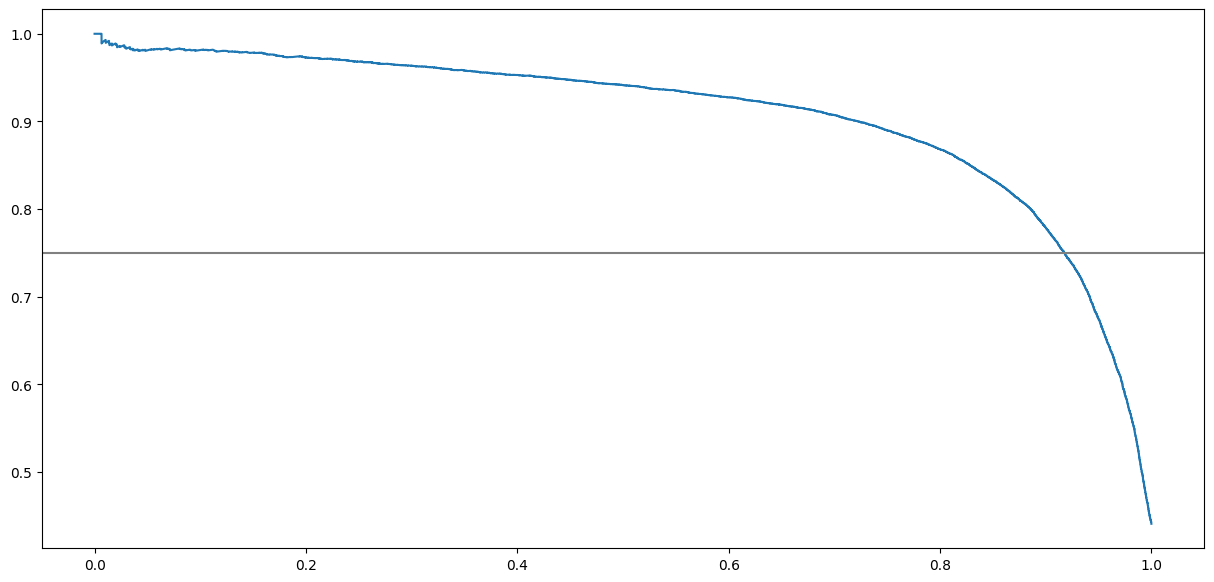

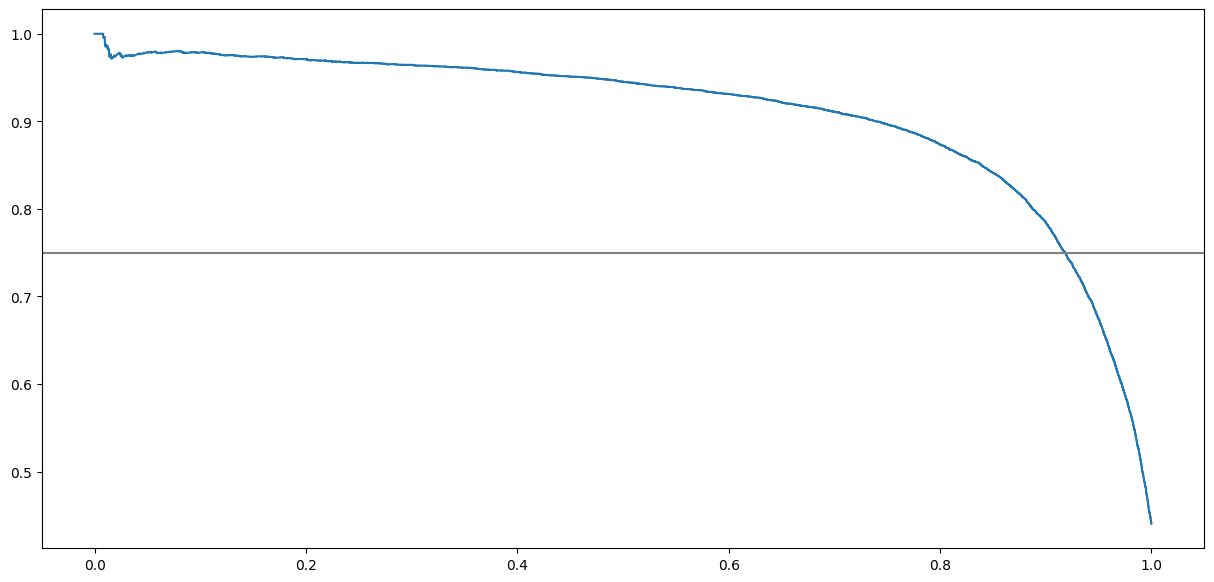

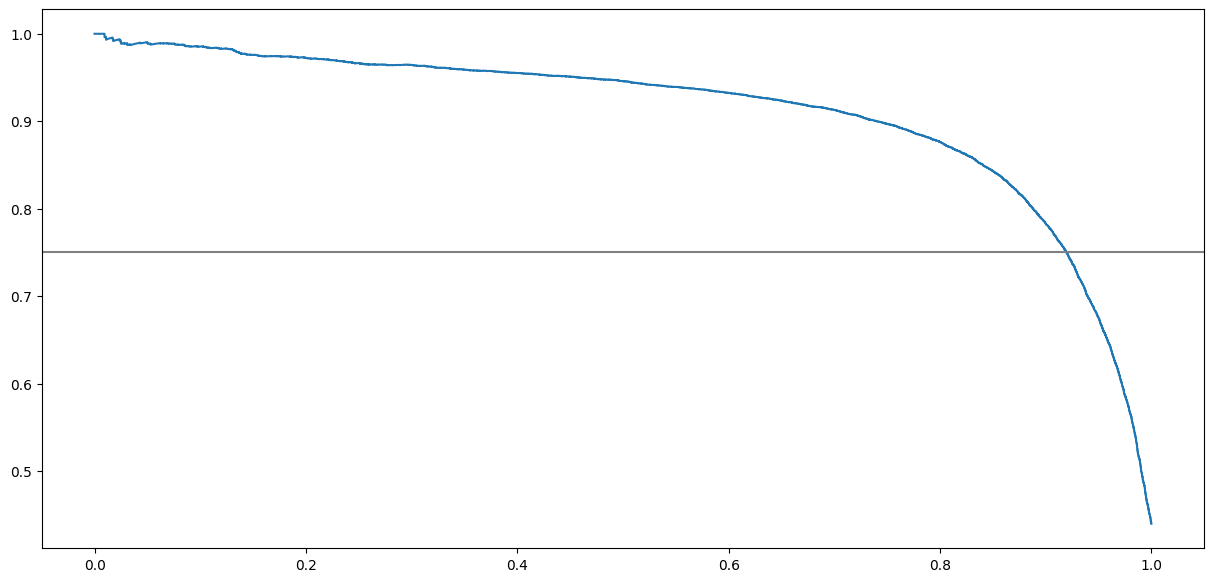

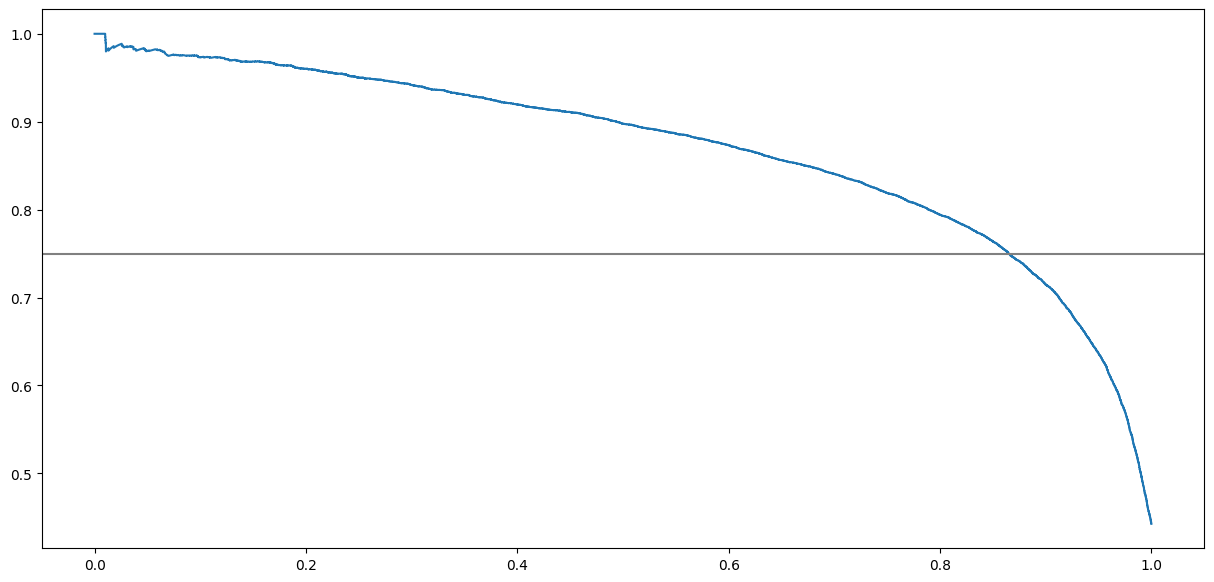

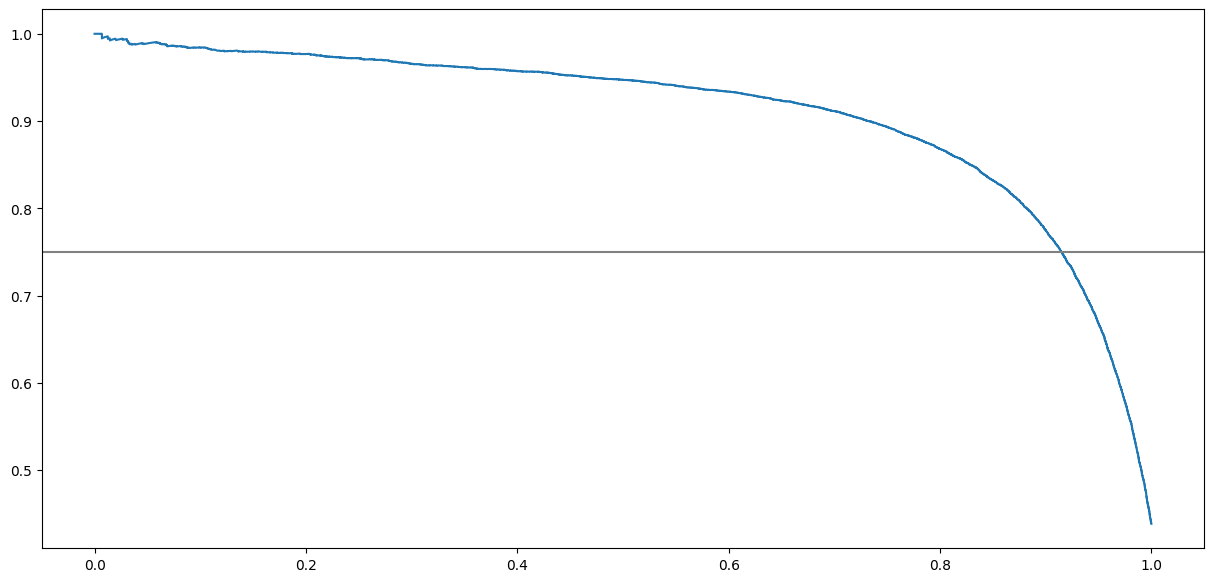

In [70]:
catboost_params = {
    'iterations': 100000,
    'learning_rate': 0.01,
    "loss_function": 'CrossEntropy',
    'verbose': 100,
    "task_type": "GPU",
    "devices": '0',
    'early_stopping_rounds': 50,
    'random_seed': 42, 
    'depth': 6
}

pr_aucs = []

models = []

for split_i, split in enumerate(splits):
    split_features = features.copy()
    split_feats = feats.copy()
    split_feats = [s for s in split_feats if "deberta_" not in s or ("deberta_" in s and str(split_i) in s)]
    split_features = split_features[split_feats + ["target", "variantid1", "variantid2", "cat3_grouped"]]
    X_train = split_features.iloc[split[0]]
    X_test = split_features.iloc[split[1]]
    X_train, X_val = train_test_split(
        X_train, 
        test_size=0.1, random_state=42,
    #     stratify=X_train[["target", "cat3_grouped"]]
    )

    X_train.to_parquet(f"/root/fold_{split_i}_train.parquet")
    X_test.to_parquet(f"/root/fold_{split_i}_test.parquet")
    X_val.to_parquet(f"/root/fold_{split_i}_val.parquet")